In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import rasterio as rio
import functions as f
import xarray as xr
from importlib import reload
import os

10it [02:35, 15.58s/it]
c:\Users\croge\OneDrive\Documents\cours EPFL\MA3\ML_project\UHI_prediction\functions.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


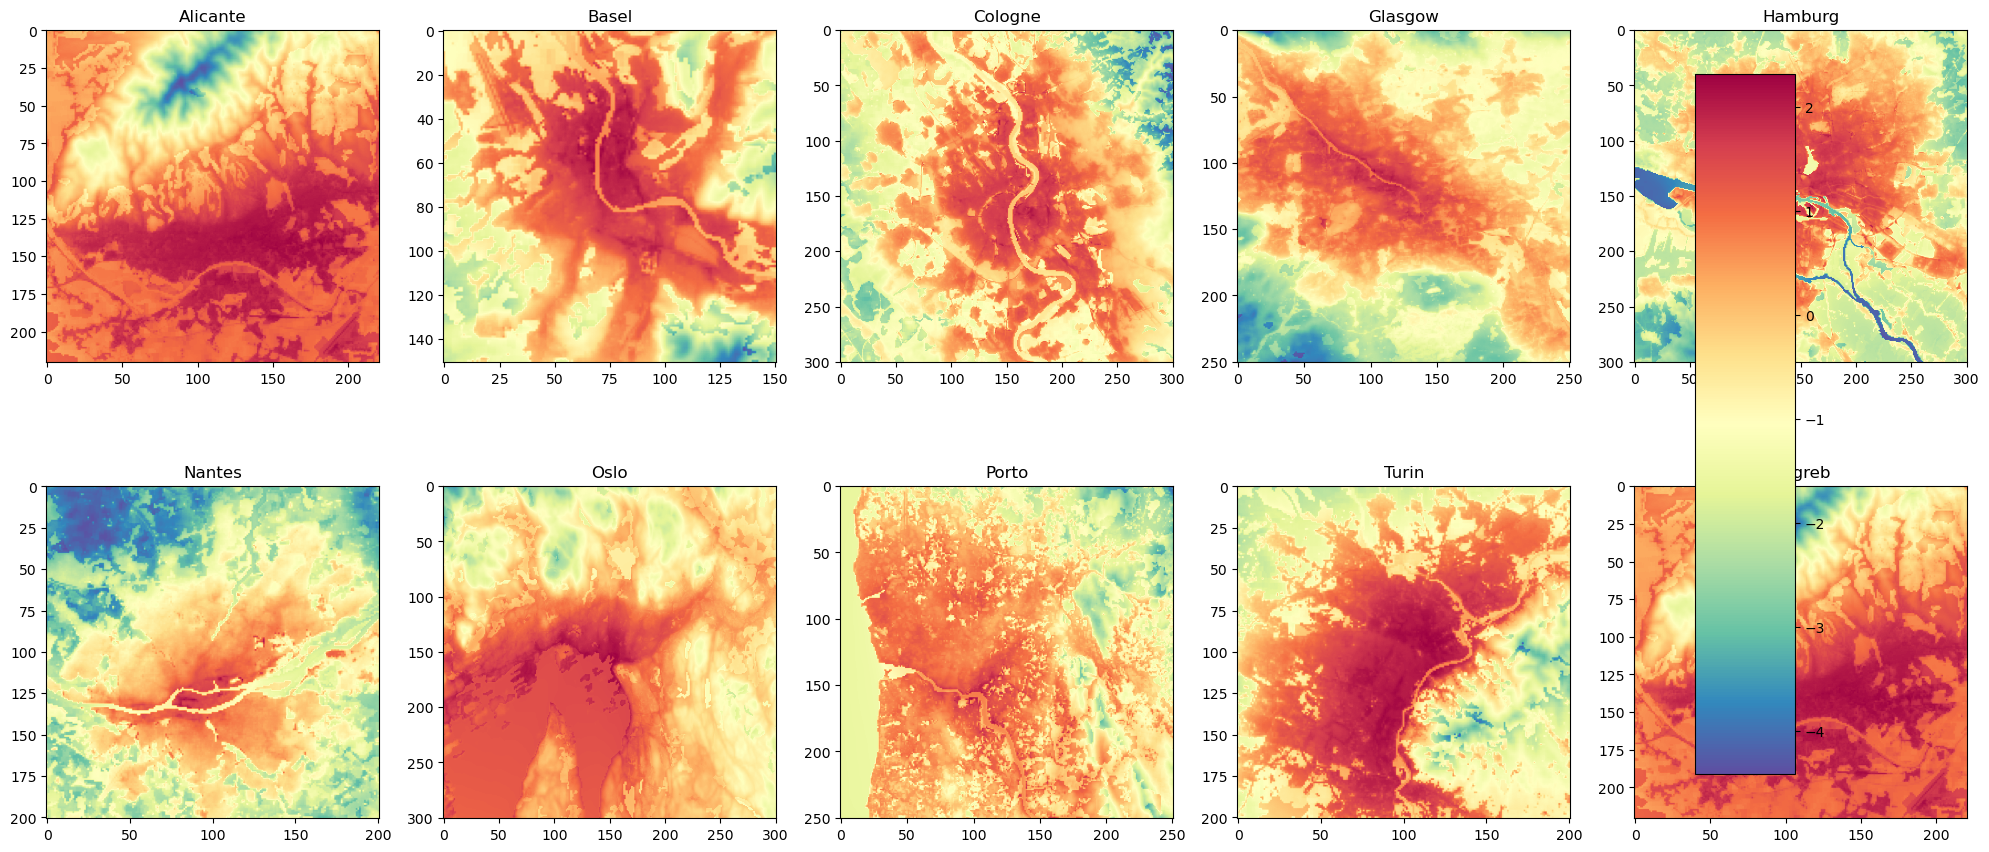

In [23]:
reload(f)

f.plot_avg_deltaT('data')

In [144]:


import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd

# Set the paths to your input and output raster files
input_raster_path = "elevation\eea_r_4326_1_km_elevation-map-europe_p_2004_v01_r00\elevationeurope1x1.tif"
output_raster_path = "elevation\eea_r_4326_1_km_elevation-map-europe_p_2004_v01_r00\elevationeurope1x1_reproj2.tif"

# Set the desired CRS
target_crs = "EPSG:4326"  # Change this to the CRS you want

# Read the input raster file
with rasterio.open(input_raster_path) as src:
    # Define the transformation settings
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )

    # Update metadata
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create the output raster file
    with rasterio.open(output_raster_path, 'w', **kwargs) as dst:
        # Reproject the data
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest  # You can choose a different resampling method if needed
            )

In [106]:
elevation = rio.open(r"elevation\eea_r_4326_1_km_elevation-map-europe_p_2004_v01_r00\elevationeurope1x1_reproj.tif")

In [6]:
#open the GTiff file with rasterio

reload(f)


pop_day_europe = rio.open(r'data_day_30ss\ENACT_POP_D072011_EU28_R2020A_4326_30ss_V1_0.tif')
pop_night_europe = rio.open(r'data_night_30ss\ENACT_POP_N072011_EU28_R2020A_4326_30ss_V1_0.tif')
elevation = rio.open(r"elevation\eea_r_4326_1_km_elevation-map-europe_p_2004_v01_r00\elevationeurope1x1_reproj2.tif")
folder = 'data'

#When selecting the data, make attnetion to the presence of mountains around (or we have to find the elevation data and add it)

df = f.process_data(folder, pop_day_europe, pop_night_europe, elevation, 100000)


  0%|          | 0/6 [00:00<?, ?it/s]

(16963944,) (16963944,)


c:\Users\croge\OneDrive\Documents\cours EPFL\MA3\ML_project\UHI_prediction\functions.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  city_df = pd.concat([city_df, pd.DataFrame({'temp': temp_file.tas.values.flatten()[indexes],
 17%|█▋        | 1/6 [00:11<00:58, 11.69s/it]

(67407144,) (67407144,)


 33%|███▎      | 2/6 [00:30<01:02, 15.63s/it]

(46872744,) (46872744,)


 50%|█████     | 3/6 [00:46<00:48, 16.18s/it]

(67407144,) (67407144,)


 67%|██████▋   | 4/6 [01:02<00:31, 15.92s/it]

(30058344,) (30058344,)


 83%|████████▎ | 5/6 [01:15<00:14, 14.75s/it]

(30058344,) (30058344,)


100%|██████████| 6/6 [01:27<00:00, 14.58s/it]


In [7]:
df.describe()

,temp,pop,wind,hum,deltaT,elevation,isrural
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,288502.0
mean,290.948364,901.272269,1.521849,68.783096,0.463019,44.037275,1.0
std,4.180572,1688.580467,1.342570,16.993940,0.981128,38.805052,0.0
min,277.533142,-200.000000,0.010000,17.501057,-4.958008,0.000000,1.0
25%,287.839996,8.494058,0.544089,55.996331,-0.099091,12.000000,1.0
50%,290.417374,156.347552,1.172232,70.309124,0.328796,23.000000,1.0
75%,293.773453,1154.697551,2.152434,82.900982,0.891388,86.000000,1.0
max,307.406982,20261.874481,10.723372,100.000000,6.449158,130.000000,1.0


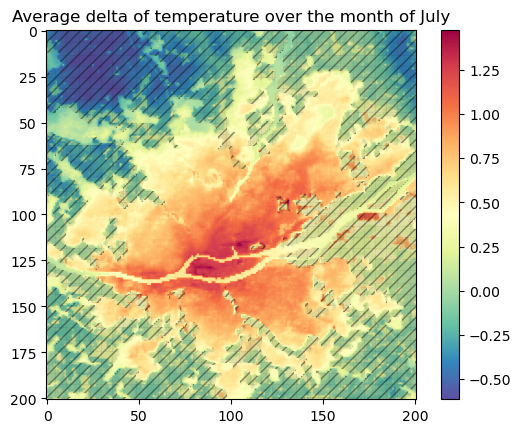

In [17]:
'''#import patches
from matplotlib import patches

#group by pixel number and compute the mean of temp_delta
data_df_mean_dt = data_df_aug.groupby(['pixel_number']).mean()


#reshape the dataframe into a 201x201 image and plot it
data_df_mean_dt = data_df_mean_dt.temp_delta.values.reshape(201,201)
data_df_mean_dt = np.flipud(data_df_mean_dt)

data_urban_mask = data_urban.urban.values.reshape(201,201)
data_urban_mask = np.flipud(data_urban_mask)

plt.imshow(data_df_mean_dt, cmap='Spectral_r')
plt.colorbar()
plt.imshow(data_urban_mask, cmap='gray', alpha=0)
ax = plt.gca()
for p in range(201):
    for q in range(201):
        if data_urban_mask[p,q] == 1:
            ax.add_patch(patches.Rectangle((q,p),1,1, fill=False, lw = 0.1, hatch='///', alpha=0.4))


plt.title('Average delta of temperature over the month of July')
plt.show()
'''

# Data processing

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

df_sampled = df.sample(100000)
df_sampled.fillna(0, inplace=True)
X = df_sampled.drop(['deltaT', 'city'], axis=1)
y = df_sampled.deltaT

#standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Support Vector Machine

In [6]:
#train a support vector machine to predict the temperature delta
from sklearn.svm import SVR


svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1, verbose=True)
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mean_squared_error(y_test, y_pred)
r2_score(y_test, y_pred)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))



[LibSVM]

# Multi-layer Perceptron regressor

In [125]:
#train a MLP regressor to predict the temperature delta with grid search
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

mlp = MLPRegressor(max_iter=500, verbose=True, hidden_layer_sizes=(100), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, shuffle=True, random_state=None, tol=0.001, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

mean_squared_error(y_test, y_pred)
r2_score(y_test, y_pred)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

Iteration 1, loss = 0.37047550
Iteration 2, loss = 0.33587247
Iteration 3, loss = 0.32377429
Iteration 4, loss = 0.31656915
Iteration 5, loss = 0.31108970
Iteration 6, loss = 0.30619818
Iteration 7, loss = 0.30234536
Iteration 8, loss = 0.29870977
Iteration 9, loss = 0.29545710
Iteration 10, loss = 0.29251395
MSE:  0.5740407355321979
R2:  0.40419675229114405


c:\Users\croge\anaconda3\envs\ML\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


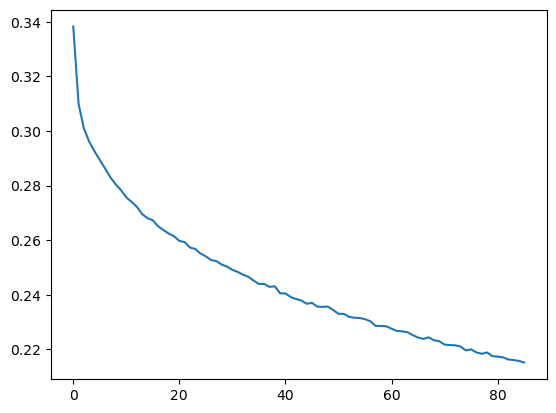

In [73]:
#plot the loss evolution
plt.plot(mlp.loss_curve_)
plt.show()

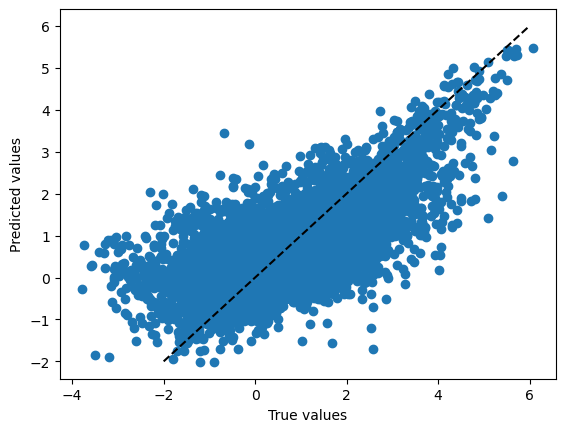

In [72]:
plt.scatter(y_test, y_pred)
plt.plot([-2, 6], [-2, 6], '--k')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

# Decision Tree regressor

MSE:  0.2714159076475186
R2:  0.7134477656482627


Text(0, 0.5, 'Predicted values')

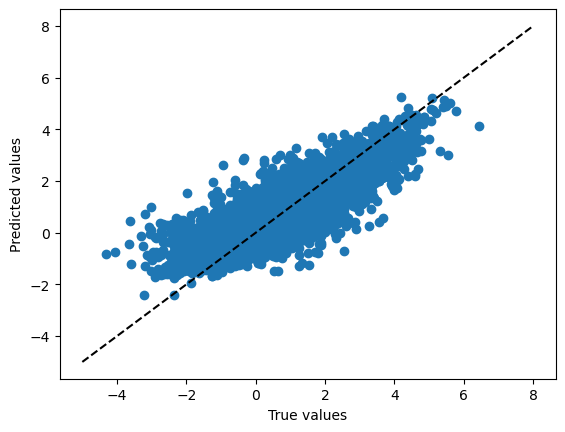

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


rf = RandomForestRegressor(n_estimators=25, max_depth=20, min_samples_split=2)
                                                       
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mean_squared_error(y_test, y_pred)
r2_score(y_test, y_pred)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.plot([-5, 8], [-5, 8], 'k--')
plt.xlabel('True values')
plt.ylabel('Predicted values')


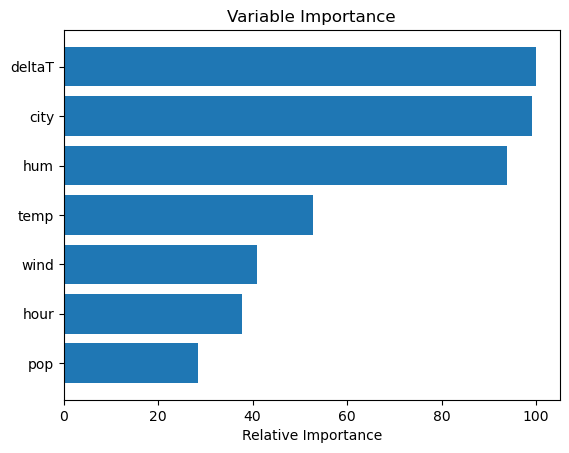

In [12]:
#plot the feature importance
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


# Gradient Boosting regressor

In [ ]:
#Train a gradient boosting regressor
from sklearn.ensemble import HistGradientBoostingRegressor

gb = HistGradientBoostingRegressor(max_iter=1000, verbose=2)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

mean_squared_error(y_test, y_pred)
r2_score(y_test, y_pred)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))



# Extra Trees regressor

In [19]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm


etr = ExtraTreesRegressor(n_estimators=30, max_depth=20)

# Fit the model with the training data
etr.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = etr.predict(X_test)

# Evaluate the model performance
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))



MSE:  0.2710448741318074
R2:  0.7244233643633126


Text(0, 0.5, 'Predicted values')

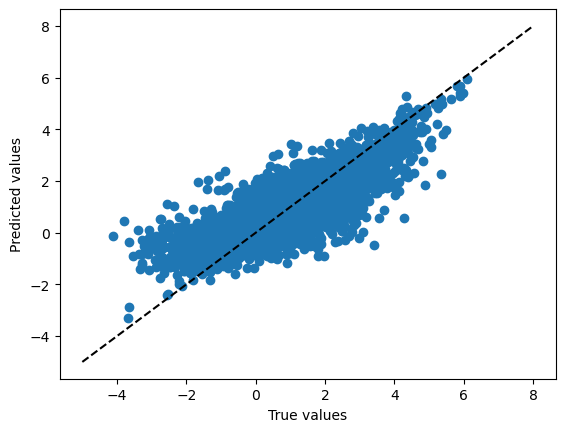

In [20]:
plt.scatter(y_test, y_pred)
plt.plot([-5, 8], [-5, 8], 'k--')
plt.xlabel('True values')
plt.ylabel('Predicted values')

In [ ]:
#close all the files
pop_day_europe.close()
pop_night_europe.close()
elevation.close()
